In [62]:
# pyright: basic

# pynamicalsys Basin Stability Estimation - Pendulum

This notebook replicates the pendulum case study (`main_pendulum_case1.py`) using pynamicalsys.

## Pendulum Dynamics

$$\frac{d\theta}{dt} = \dot{\theta}$$
$$\frac{d\dot{\theta}}{dt} = -\alpha \dot{\theta} + T - K \sin(\theta)$$

Where:
- $\theta$ is the angle
- $\dot{\theta}$ is the angular velocity
- $\alpha$ is the damping coefficient
- $T$ is the external torque
- $K$ is the stiffness coefficient

## Known Bug

pynamicalsys 1.5.0 has a bug in `generate_stroboscopic_map()` where the adaptive RK45 step size can grow larger than `sampling_time`. When this happens:

1. After one step, `time_curr` overshoots `time_target` by more than one sampling period
2. The inner while loop has 0 iterations (already past target)
3. `time_curr == time_prev` → division by zero

**Location**: `pynamicalsys/continuous_time/trajectory_analysis.py` line 373:
```python
lam = (time_target - time_prev) / (time_curr - time_prev)  # div by zero!
```

**Workaround**: Use `sampling_time > max adaptive step` (~2π works for this pendulum).

**Tested with**: pynamicalsys 1.5.0, Numba 0.63.1

## Setup

In [63]:
# pyright: basic
import time

import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from numpy.typing import NDArray
from pynamicalsys import ContinuousDynamicalSystem

In [64]:
# Pendulum parameters
ALPHA = 0.1  # damping coefficient
TORQUE = 0.5  # external torque
K = 1.0  # stiffness coefficient

params: list[float] = [ALPHA, TORQUE, K]

In [65]:
@njit
def pendulum_equations(
    time: float,  # noqa: ARG001
    state: NDArray[np.float64],
    params: NDArray[np.float64],
) -> NDArray[np.float64]:
    """Pendulum ODE equations compatible with pynamicalsys."""
    alpha, torque, k = params[0], params[1], params[2]

    dudt = np.zeros_like(state)
    dudt[0] = state[1]
    dudt[1] = -alpha * state[1] + torque - k * np.sin(state[0])

    return dudt


@njit
def pendulum_jacobian(
    time: float,  # noqa: ARG001
    state: NDArray[np.float64],
    params: NDArray[np.float64],
) -> NDArray[np.float64]:
    """Jacobian of pendulum equations for Lyapunov computation.
    
    J = [[∂f1/∂θ, ∂f1/∂θ̇],
         [∂f2/∂θ, ∂f2/∂θ̇]]
      = [[0,         1    ],
         [-K·cos(θ), -α   ]]
    """
    alpha = params[0]
    k = params[2]
    theta = state[0]

    J = np.zeros((2, 2))
    J[0, 0] = 0.0
    J[0, 1] = 1.0
    J[1, 0] = -k * np.cos(theta)
    J[1, 1] = -alpha

    return J

In [66]:
# pyright: basic
# Create dynamical system
ds = ContinuousDynamicalSystem(
    equations_of_motion=pendulum_equations,
    jacobian=pendulum_jacobian,
    system_dimension=2,
    number_of_parameters=3,
)
ds.set_parameters(params)
ds.integrator("rk45", atol=1e-6, rtol=1e-8)

## Template Trajectories

From the pybasin setup, we have two attractors:
- **Fixed Point (FP)**: Initial condition `[0.4, 0.0]`
- **Limit Cycle (LC)**: Initial condition `[2.7, 0.0]`

In [67]:
# Template initial conditions from setup_pendulum_system.py
template_y0: list[list[float]] = [
    [0.4, 0.0],   # Fixed Point
    [2.7, 0.0],   # Limit Cycle
]
template_labels: list[str] = ["FP", "LC"]

total_time: int = 100
transient_time: int = 50

In [68]:
# Generate trajectories for each template
trajectories: list[NDArray[np.floating]] = []
for y0 in template_y0:
    traj = ds.trajectory(y0, total_time, parameters=params)
    trajectories.append(traj)
    print(f"Trajectory from {y0}: shape = {traj.shape}")

Trajectory from [0.4, 0.0]: shape = (161, 3)
Trajectory from [2.7, 0.0]: shape = (672, 3)


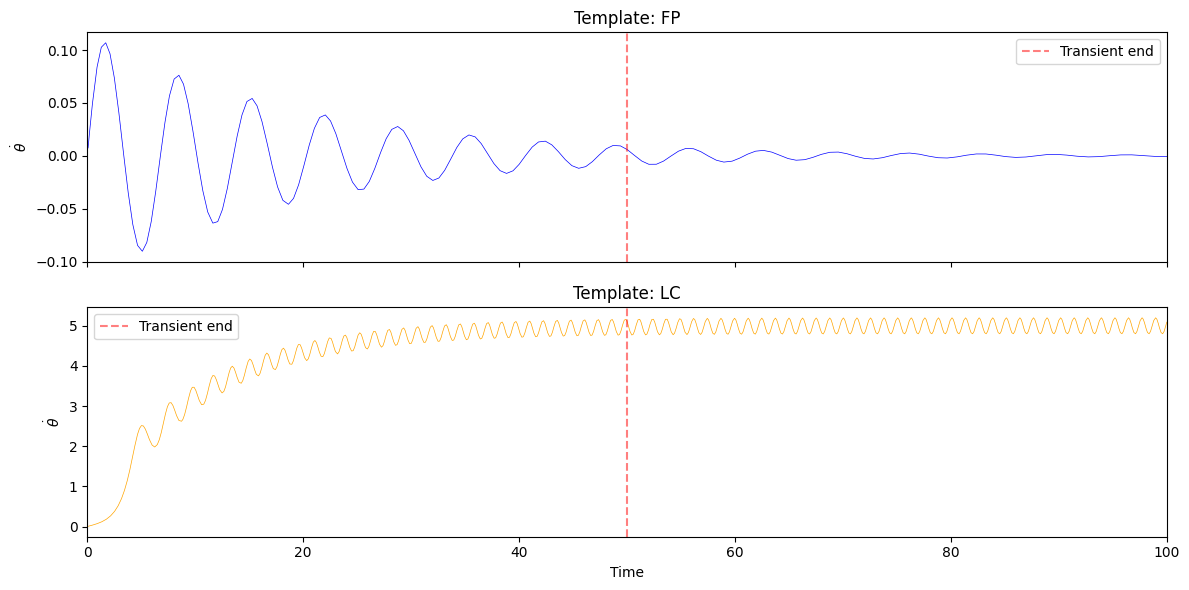

In [69]:
# pyright: basic
# Plot time series for angular velocity (state variable 1)
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

colors: list[str] = ["blue", "orange"]
for i, (traj, label) in enumerate(zip(trajectories, template_labels)):
    axes[i].plot(traj[:, 0], traj[:, 2], color=colors[i], linewidth=0.5)
    axes[i].set_ylabel(r"$\dot{\theta}$")
    axes[i].set_title(f"Template: {label}")
    axes[i].axvline(x=transient_time, color="red", linestyle="--", alpha=0.5, label="Transient end")
    axes[i].legend()

axes[-1].set_xlabel("Time")
axes[-1].set_xlim(0, total_time)
plt.tight_layout()
plt.show()

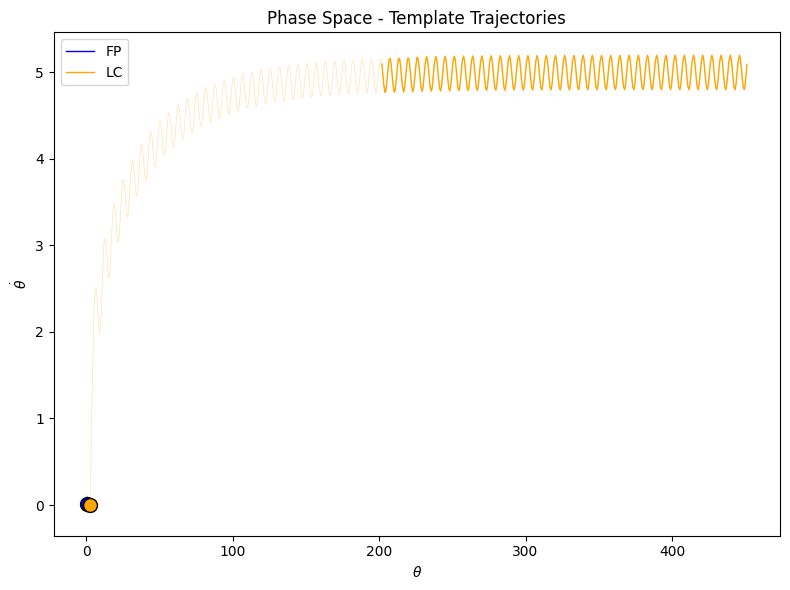

In [70]:
# pyright: basic
# Plot phase space trajectories
fig, ax = plt.subplots(figsize=(8, 6))

for i, (traj, label) in enumerate(zip(trajectories, template_labels)):
    # Plot full trajectory
    ax.plot(traj[:, 1], traj[:, 2], color=colors[i], linewidth=0.5, alpha=0.3)
    # Highlight steady state (after transient)
    steady_mask = traj[:, 0] > transient_time
    ax.plot(traj[steady_mask, 1], traj[steady_mask, 2], color=colors[i], linewidth=1, label=label)
    # Mark initial condition
    ax.scatter(traj[0, 1], traj[0, 2], color=colors[i], s=100, marker="o", edgecolors="black", zorder=5)

ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\dot{\theta}$")
ax.set_title("Phase Space - Template Trajectories")
ax.legend()
plt.tight_layout()
plt.show()

## Stroboscopic Map

Generate stroboscopic maps for the template trajectories to visualize the attractors in feature space.

In [71]:
# Stroboscopic map parameters
num_samples: int = 100
sampling_time: float = 2 * np.pi  # Must be > max adaptive step to avoid bug
sm_transient_time: float = 900.0

In [72]:
# Generate stroboscopic maps for templates
stroboscopic_maps: list[NDArray[np.floating]] = []
for y0, label in zip(template_y0, template_labels):
    sm = ds.stroboscopic_map(
        y0, 
        num_samples, 
        sampling_time=sampling_time, 
        parameters=params, 
        transient_time=sm_transient_time
    )
    stroboscopic_maps.append(sm)
    print(f"{label}: stroboscopic map shape = {sm.shape}")

FP: stroboscopic map shape = (100, 3)
LC: stroboscopic map shape = (100, 3)


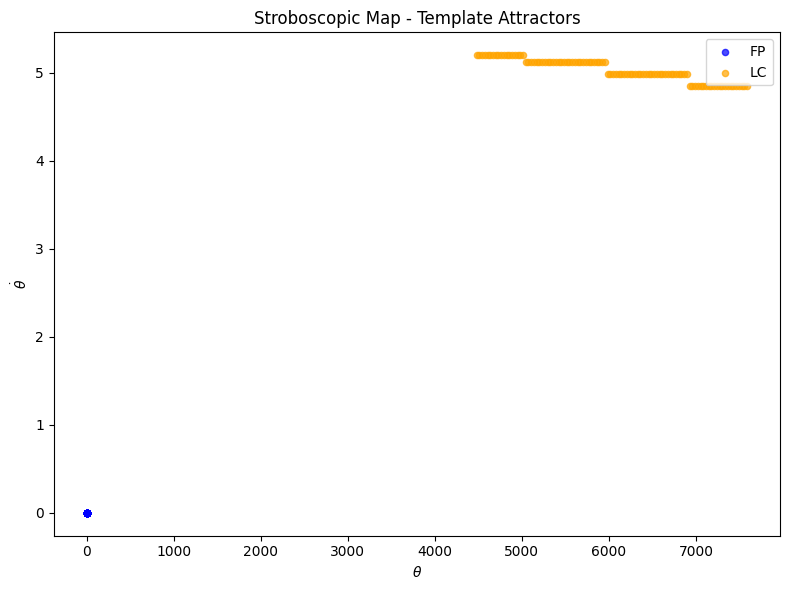

In [73]:
# pyright: basic
# Plot stroboscopic maps
fig, ax = plt.subplots(figsize=(8, 6))

for i, (sm, label) in enumerate(zip(stroboscopic_maps, template_labels)):
    ax.scatter(sm[:, 1], sm[:, 2], color=colors[i], s=20, alpha=0.7, label=label)

ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\dot{\theta}$")
ax.set_title("Stroboscopic Map - Template Attractors")
ax.legend()
plt.tight_layout()
plt.show()

## Basin Stability Estimation

Now we compute basin stability using 10,000 random initial conditions.

In [74]:
def generate_initial_conditions(
    n: int, 
    params: list[float], 
    seed: int = 42
) -> NDArray[np.float64]:
    """Generate random initial conditions uniformly distributed in state space."""
    rng = np.random.default_rng(seed)

    _, torque, k = params
    theta_offset = np.arcsin(torque / k)

    theta_min = -np.pi + theta_offset
    theta_max = np.pi + theta_offset
    theta_dot_min = -10.0
    theta_dot_max = 10.0

    theta_vals = rng.uniform(theta_min, theta_max, n)
    theta_dot_vals = rng.uniform(theta_dot_min, theta_dot_max, n)

    return np.column_stack([theta_vals, theta_dot_vals])

In [75]:
# Generate initial conditions
n: int = 10000
u: NDArray[np.float64] = generate_initial_conditions(n, params, seed=42)
print(f"Initial conditions shape: {u.shape}")

Initial conditions shape: (10000, 2)


In [76]:
# Basin of attraction parameters
num_intersections: int = 100
bs_transient_time: float = 900.0
bs_sampling_time: float = 2 * np.pi  # Must be > max adaptive step to avoid bug
eps: float = 10.0
min_samples: int = 100

print("Configuration:")
print(f"  - Transient time: {bs_transient_time}")
print(f"  - Stroboscopic samples: {num_intersections}")
print(f"  - Sampling time: {bs_sampling_time:.4f} (2π)")
print(f"  - DBSCAN eps: {eps}")
print(f"  - DBSCAN min_samples: {min_samples}")

Configuration:
  - Transient time: 900.0
  - Stroboscopic samples: 100
  - Sampling time: 6.2832 (2π)
  - DBSCAN eps: 10.0
  - DBSCAN min_samples: 100


In [77]:
# Compute basin of attraction
start_time = time.perf_counter()

basin_labels: NDArray[np.int32] = ds.basin_of_attraction(
    u=u,
    num_intersections=num_intersections,
    transient_time=bs_transient_time,
    map_type="SM",
    sampling_time=bs_sampling_time,
    eps=eps,
    min_samples=min_samples,
)

elapsed_time = time.perf_counter() - start_time
print(f"Computation completed in {elapsed_time:.2f} seconds")

Computation completed in 14.39 seconds


In [78]:
# Compute basin stability
unique_labels, counts = np.unique(basin_labels, return_counts=True)
bs_vals: dict[int, float] = {int(label): count / n for label, count in zip(unique_labels, counts)}

print("\nBasin Stability Results:")
print("=" * 40)
for label, bs in sorted(bs_vals.items()):
    if label == -1:
        print(f"  Noise (unclassified): {bs:.4f} ({int(bs * n)} samples)")
    else:
        print(f"  Attractor {label}: {bs:.4f} ({int(bs * n)} samples)")

print("\nExpected (from pybasin):")
print("  FP: ~0.152")
print("  LC: ~0.848")


Basin Stability Results:
  Noise (unclassified): 0.0010 (10 samples)
  Attractor 0: 0.8454 (8454 samples)
  Attractor 1: 0.1536 (1535 samples)

Expected (from pybasin):
  FP: ~0.152
  LC: ~0.848


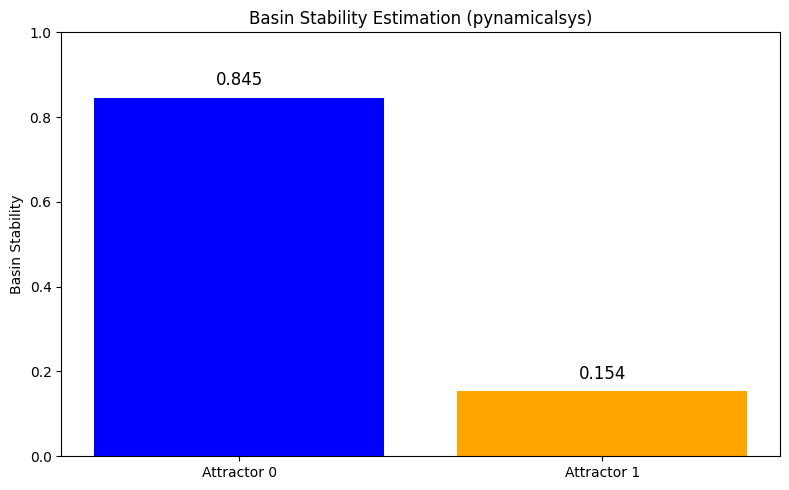

In [79]:
# pyright: basic
# Plot basin stability bar chart
fig, ax = plt.subplots(figsize=(8, 5))

# Filter out noise
labels_plot: list[int] = [l for l in sorted(bs_vals.keys()) if l != -1]
values_plot: list[float] = [bs_vals[l] for l in labels_plot]
label_names: list[str] = [f"Attractor {l}" for l in labels_plot]

bars = ax.bar(label_names, values_plot, color=["blue", "orange"][:len(labels_plot)])
ax.set_ylabel("Basin Stability")
ax.set_title("Basin Stability Estimation (pynamicalsys)")
ax.set_ylim(0, 1)

# Add value labels on bars
for bar, val in zip(bars, values_plot):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f"{val:.3f}", ha="center", va="bottom", fontsize=12)

plt.tight_layout()
plt.show()

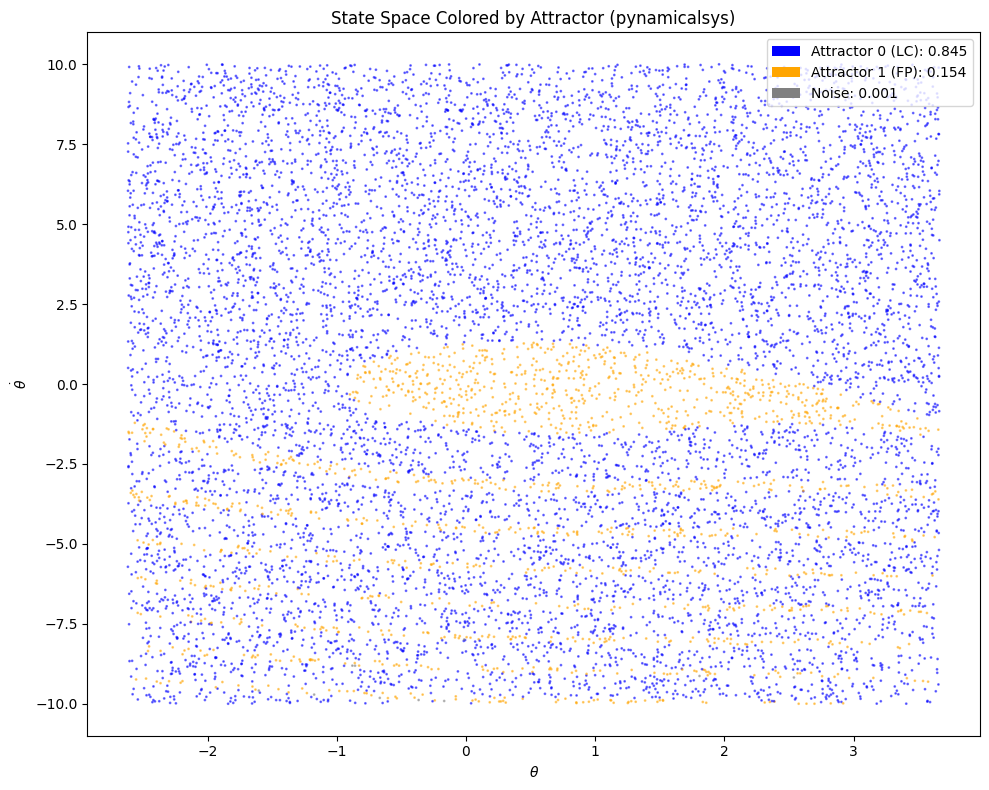

In [80]:
# pyright: basic
# Plot state space colored by attractor
fig, ax = plt.subplots(figsize=(10, 8))

# Color map for attractors
color_map: dict[int, str] = {-1: "gray", 0: "blue", 1: "orange"}
point_colors: list[str] = [color_map.get(int(l), "black") for l in basin_labels]

scatter = ax.scatter(u[:, 0], u[:, 1], c=point_colors, s=1, alpha=0.5)

ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\dot{\theta}$")
ax.set_title("State Space Colored by Attractor (pynamicalsys)")

# Add legend
from matplotlib.patches import Patch
legend_elements: list[Patch] = [
    Patch(facecolor="blue", label=f"Attractor 0 (LC): {bs_vals.get(0, 0):.3f}"),
    Patch(facecolor="orange", label=f"Attractor 1 (FP): {bs_vals.get(1, 0):.3f}"),
]
if -1 in bs_vals:
    legend_elements.append(Patch(facecolor="gray", label=f"Noise: {bs_vals[-1]:.3f}"))
ax.legend(handles=legend_elements, loc="upper right")

plt.tight_layout()
plt.show()

In [81]:
# Benchmark with 100,000 initial conditions
n_large: int = 100000
u_large: NDArray[np.float64] = generate_initial_conditions(n_large, params, seed=42)

print(f"Running basin_of_attraction with {n_large:,} initial conditions...")

start_time = time.perf_counter()

basin_labels_large: NDArray[np.int32] = ds.basin_of_attraction(
    u=u_large,
    num_intersections=num_intersections,
    transient_time=bs_transient_time,
    map_type="SM",
    sampling_time=bs_sampling_time,
    eps=eps,
    min_samples=min_samples,
)

elapsed_large = time.perf_counter() - start_time
print(f"Completed in {elapsed_large:.2f} seconds ({elapsed_large/60:.2f} minutes)")
print(f"Throughput: {n_large/elapsed_large:.0f} ICs/second")

Running basin_of_attraction with 100,000 initial conditions...
Completed in 113.85 seconds (1.90 minutes)
Throughput: 878 ICs/second


## Lyapunov Exponents

Compute Lyapunov exponents to characterize the attractors.

In [82]:
# pyright: basic
# High precision for Lyapunov computation
ds.integrator("rk45", atol=1e-12, rtol=1e-12)

lyap_total_time: int = 5000
lyap_transient: int = 1000

print("Lyapunov Exponents:")
print("=" * 40)
for y0, label in zip(template_y0, template_labels):
    lyap = ds.lyapunov(y0, lyap_total_time, parameters=params, transient_time=lyap_transient)
    print(f"{label}: λ = {lyap}")

Lyapunov Exponents:
FP: λ = [-0.04998868 -0.05001132]
LC: λ = [ 0.00054134 -0.10054134]


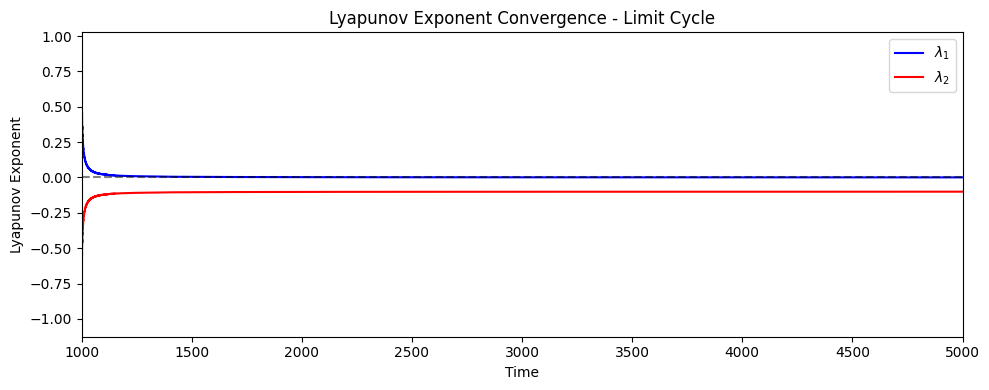

In [83]:
# pyright: basic
# Plot Lyapunov exponent convergence for LC
lyap_history: NDArray[np.floating] = ds.lyapunov(
    template_y0[1],  # LC
    lyap_total_time, 
    parameters=params, 
    transient_time=lyap_transient,
    return_history=True
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(lyap_history[:, 0], lyap_history[:, 1], "b-", label=r"$\lambda_1$")
ax.plot(lyap_history[:, 0], lyap_history[:, 2], "r-", label=r"$\lambda_2$")
ax.axhline(y=0, color="k", linestyle="--", alpha=0.5)
ax.set_xlabel("Time")
ax.set_ylabel("Lyapunov Exponent")
ax.set_title("Lyapunov Exponent Convergence - Limit Cycle")
ax.set_xlim(lyap_transient, lyap_total_time)
ax.legend()
plt.tight_layout()
plt.show()